## 2장. 트랜스포머 
#### 도전 과제 2번. 감성 분석

In [1]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

2025-09-21 22:28:57.138013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758461337.152921 1325932 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758461337.157318 1325932 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758461337.171051 1325932 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758461337.171064 1325932 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758461337.171066 1325932 computation_placer.cc:177] computation placer alr

In [2]:
# 1) 체크포인트/모델
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint).to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [3]:
# 2) 데이터: GLUE/SST-2 (모델 학습 태스크와 동일, label: 0=negative, 1=positive)
ds = load_dataset("glue", "sst2")
small_dataset = ds["validation"]  

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [4]:
# 3) 단일 문장 테스트
inputs = tokenizer("This movie was terrible!", truncation=True, return_tensors="pt").to(device)
with torch.no_grad():
    logits = model(**inputs).logits
pred_id = int(logits.argmax(dim=-1).item())

print("Single example predicted class id:", pred_id, "| label:", model.config.id2label[pred_id])

Single example predicted class id: 0 | label: NEGATIVE


In [5]:
# 4) 배치 추론 함수 
def predict_batch(batch):
    enc = tokenizer(batch["sentence"], truncation=True, padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**enc)
        preds = out.logits.argmax(dim=-1).detach().cpu().numpy()
    return {"pred": preds}

In [6]:
updated_dataset = small_dataset.map(predict_batch, batched=True, batch_size=64)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [7]:
# 5) 메트릭 계산 (accuracy, f1, confusion_matrix)
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
cm_metric = evaluate.load("confusion_matrix")

y_true = updated_dataset["label"]
y_pred = updated_dataset["pred"]

acc = acc_metric.compute(references=y_true, predictions=y_pred)["accuracy"]
f1  = f1_metric.compute(references=y_true, predictions=y_pred, average="binary")["f1"]
cm  = cm_metric.compute(references=y_true, predictions=y_pred)["confusion_matrix"]

print(f"Accuracy: {acc:.4f}")
print(f"F1 (positive=1): {f1:.4f}")
print("Confusion Matrix:\n", np.array(cm))

Accuracy: 0.9106
F1 (positive=1): 0.9137
Confusion Matrix:
 [[381  47]
 [ 31 413]]


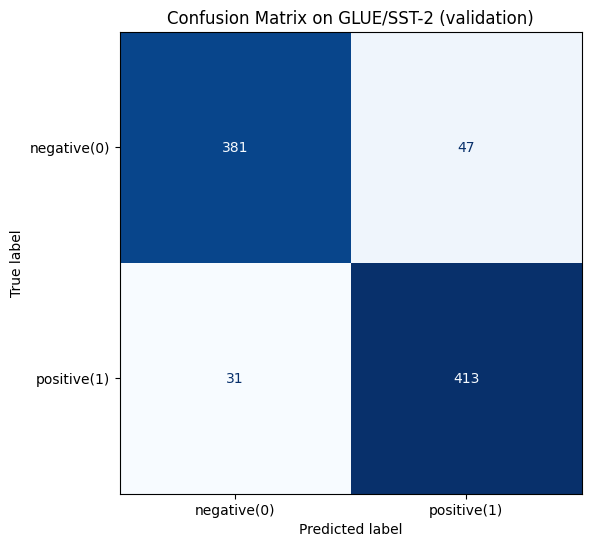

In [8]:
# 6) 혼동행렬 시각화
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm), display_labels=["negative(0)", "positive(1)"])
disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)
plt.title("Confusion Matrix on GLUE/SST-2 (validation)")
plt.tight_layout()
plt.show()